In [2]:
coins_to_train = ['EOS','TRX','ADA','SOL']

In [4]:
from tensortrade.data.cdd import CryptoDataDownload
import pandas as pd
import numpy as np
import ta
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None
import pywt
from statsmodels.robust import mad
import numpy as np

def prepare_data(data, coin):
    """ cylicial feature encoding following: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca"""  
    data['dayOfWeek'] = data['%s:date' %coin].dt.dayofweek
    dataDayOfWeekMax = data['dayOfWeek'].max()
    data['%s:dayOfWeek_sin' % coin] = np.sin(2 * np.pi * data['dayOfWeek']/dataDayOfWeekMax)
    data['%s:dayOfWeek_cos' % coin] = np.cos(2 * np.pi * data['dayOfWeek']/dataDayOfWeekMax)
    """ Date cos & sin """
    data['dayInYear'] = data['%s:date' % coin].apply(lambda x: int(x.strftime('%j')))
    dataDayInYearMax = data['dayInYear'].max()
    data['%s:dayInYear_sin' % coin] = np.sin(2 * np.pi * data['dayInYear']/dataDayInYearMax)
    data['%s:dayInYear_cos' % coin] = np.cos(2 * np.pi * data['dayInYear']/dataDayInYearMax)
    """ Time cos & sin """
    data["timeOfDay"] = (data['%s:date' % coin].dt.hour*60) + data['%s:date' % coin].dt.minute
    dataTimeOfDayMax = data['timeOfDay'].max()
    data['%s:timeOfDay_sin' % coin] = np.sin(2 * np.pi * data['timeOfDay']/dataTimeOfDayMax)
    data['%s:timeOfDay_cos' % coin] = np.cos(2 * np.pi * data['timeOfDay']/dataTimeOfDayMax)
    """ Month cos & sin """
    data["monthInYear"] = data['%s:date' % coin].dt.month
    dataMonthInYearMax = data['monthInYear'].max()
    data['%s:monthInYear_sin' % coin] = np.sin(2 * np.pi * data['monthInYear']/dataMonthInYearMax)
    data['%s:monthInYear_cos'% coin] = np.cos(2 * np.pi * data['monthInYear']/dataMonthInYearMax)
   
    data = data.set_index('%s:date' % coin)
    
    #normalize the data over MA
    data['%s:close_ma_20' % coin] = ta.trend.ema_indicator(data['%s:close' % coin], window=20, fillna=True)
    data['%s:closing_smooth' % coin] = (data['%s:close' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin] 
    data['%s:open_smooth' % coin] = (data['%s:open' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:high_smooth' % coin] = (data['%s:high' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:low_smooth' % coin] = (data['%s:low' % coin] -data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:volume_ma_20' % coin] = ta.trend.ema_indicator(data['%s:volume' % coin], window=20, fillna=True)
    data['%s:volume_smooth' % coin] = (data['%s:volume' % coin] - data['%s:volume_ma_20' % coin]) / data['%s:volume_ma_20' % coin]
   
    columns_to_drop = ['timeOfDay', 'dayOfWeek',  'monthInYear', 'dayInYear', \
                       ('%s:tradecount' % coin),('%s:unix' % coin), \
                       ('%s:open' % coin), ('%s:close' % coin), ('%s:high' % coin), ('%s:low' % coin), ('%s:volume' % coin), \
                      ('%s:close_ma_20' % coin), ('%s:volume_ma_20' % coin)]
    data = data.drop(columns_to_drop, axis=1)

    return data

def fetch_data(coins=['EOS'], candles="1h"):
    cdd = CryptoDataDownload()
    binance_data = pd.DataFrame()
    for coin in coins:
        coin_data = cdd.fetch("Binance", "USDT", coin, candles).add_prefix("%s:" % coin)
        coin_data = prepare_data(coin_data[coin_data['%s:date' % coin] >= pd.to_datetime('2021-01-01 00:00:00')],coin)
        binance_data = pd.concat((binance_data,coin_data), axis=1)
    return binance_data

data = fetch_data(coins_to_train, "1h")

### Plot cylicial features 

<AxesSubplot:>

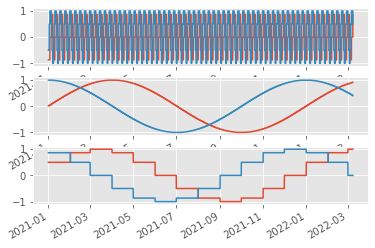

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1)                  
data['EOS:dayOfWeek_sin'].dropna().plot(ax=axes[0])
data['EOS:dayOfWeek_cos'].dropna().plot(ax=axes[0])
data['EOS:dayInYear_sin'].dropna().plot(ax=axes[1])
data['EOS:dayInYear_cos'].dropna().plot(ax=axes[1])
data['EOS:monthInYear_sin'].dropna().plot(ax=axes[2])
data['EOS:monthInYear_cos'].dropna().plot(ax=axes[2])

# Split Data

In [52]:
# 8736 is roughly 1 year of hour candles
num_datapoints = data.shape[0]
# roll by approx. 60 days - 3 months of trading days
step_size = int(0.1 * num_datapoints)


test = data[-step_size:]
validate = data[-2*step_size:-step_size]
train = data[:-2*step_size]

print(test.shape)
print(validate.shape)
print(train.shape)
print(train.index.min())
print(train.index.max())
print(validate.index.min())
print(validate.index.max())
print(test.index.min())
print(test.index.max())

(1033, 56)
(1033, 56)
(8266, 56)
2021-01-01 00:00:00
2021-12-11 22:00:00
2021-12-11 23:00:00
2022-01-23 23:00:00
2022-01-24 00:00:00
2022-03-08 00:00:00


# Normalize

### Create Training Set and Z-Score Transform

In [53]:
normalize_columns = train.filter(regex='closing|low|high|open|volume').columns

In [54]:
data_header = ['open','closing','high','low','volume']
train_normalized = train.copy()
# Calculate mean across coins per OHCLV data
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    train_normalized_temp = train_normalized[header_to_normalize]
    train_list = pd.concat((train_normalized_temp.iloc[:,0] , train_normalized_temp.iloc[:,1] , train_normalized_temp.iloc[:,2] , train_normalized_temp.iloc[:,3]), axis=0)
    mean = np.mean(train_list.dropna())
    std = np.std(train_list.dropna())
    for i in header_to_normalize:
        train_normalized[i] = (train_normalized[i] - mean)  / (3 * std)

## Validation Data

### Create Validation Set and Z-Score Transform

In [56]:
from statistics import mean
data_header = ['closing','low','high','open','volume']
train = train_normalized.copy()
validate_normalized = pd.DataFrame()
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    temp = train[header_to_normalize]
    validate_normalized_temp = validate[header_to_normalize]
    for j in range(validate.shape[0]):
        list_datapoints = []
        temp = np.append(temp, np.expand_dims(validate_normalized_temp.iloc[j,:], axis=0), axis=0)
        for coin in range(len(coin_to_train)):
            list_datapoints.extend(temp[:,coin])
        for i in range(validate_normalized_temp.shape[1]):
            index_row = temp.shape[0] - 1
            mean = np.nanmean(list_datapoints)
            std = np.nanstd(list_datapoints)
            validate_normalized.loc[j,header_to_normalize[i]] = (temp[index_row,i] - mean)  / (3 * std)
            
validate.reset_index(inplace=True)
validate = validate.drop(normalize_columns, axis=1)
validate_normalized = pd.concat((validate,validate_normalized),axis=1)
validate_normalized.set_index('index')

,EOS:symbol,EOS:dayOfWeek_sin,EOS:dayOfWeek_cos,EOS:dayInYear_sin,EOS:dayInYear_cos,EOS:timeOfDay_sin,EOS:timeOfDay_cos,EOS:monthInYear_sin,EOS:monthInYear_cos,TRX:symbol,...,ADA:high_smooth,SOL:high_smooth,EOS:open_smooth,TRX:open_smooth,ADA:open_smooth,SOL:open_smooth,EOS:volume_smooth,TRX:volume_smooth,ADA:volume_smooth,SOL:volume_smooth
index,,,,,,,,,,,,,,,,,,,,,
2021-12-11 23:00:00,EOS/USDT,-8.660254e-01,0.5,-0.337523,0.941317,-2.449294e-16,1.000000,-2.449294e-16,1.000000,TRX/USDT,...,0.044581,0.011047,0.009888,0.002875,0.043813,-0.000563,-0.114188,0.124810,-0.059765,-0.098759
2021-12-12 00:00:00,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,0.000000e+00,1.000000,-2.449294e-16,1.000000,TRX/USDT,...,0.079810,0.012400,0.012490,0.010791,0.033258,0.009354,0.106529,0.643512,1.001945,-0.078451
2021-12-12 01:00:00,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,2.697968e-01,0.962917,-2.449294e-16,1.000000,TRX/USDT,...,0.074611,0.005498,-0.000160,0.005504,0.070817,0.001805,-0.491167,0.130087,0.094157,-0.453903
2021-12-12 02:00:00,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,5.195840e-01,0.854419,-2.449294e-16,1.000000,TRX/USDT,...,0.051192,-0.002804,0.001727,-0.000220,0.039859,-0.005265,0.979239,-0.223041,-0.238462,-0.441895
2021-12-12 03:00:00,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,7.308360e-01,0.682553,-2.449294e-16,1.000000,TRX/USDT,...,0.048348,0.000519,0.021890,0.000329,0.040832,-0.008229,0.217069,-0.422985,-0.360574,-0.434243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23 19:00:00,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-8.878852e-01,0.460065,5.000000e-01,0.866025,TRX/USDT,...,-0.018172,-0.022557,-0.017591,-0.017169,-0.026073,-0.029922,0.250404,-0.311728,-0.110313,-0.082092
2022-01-23 20:00:00,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-7.308360e-01,0.682553,5.000000e-01,0.866025,TRX/USDT,...,-0.011364,-0.017827,-0.023666,-0.020425,-0.034860,-0.039074,-0.104163,-0.447324,-0.240801,-0.224063
2022-01-23 21:00:00,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-5.195840e-01,0.854419,5.000000e-01,0.866025,TRX/USDT,...,-0.008950,-0.015823,-0.009231,-0.008480,-0.015909,-0.021816,-0.410104,-0.522665,-0.413055,-0.382865


## Test Data

### Create Test Set and Z_Score Transform

In [57]:
from statistics import mean
data_header = ['closing','low','high','open','volume']
temp_train = train_normalized.copy().filter(regex='closing|low|high|open|volume')
temp_val = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
train_val = pd.concat((temp_train, temp_val),axis=0)
test_normalized = pd.DataFrame()
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    temp = train_val[header_to_normalize]
    test_normalized_temp = test[header_to_normalize]
    for j in range(test.shape[0]):
        list_datapoints = []
        temp = np.append(temp, np.expand_dims(test_normalized_temp.iloc[j,:], axis=0), axis=0)
        for coin in range(len(coin_to_train)):
            list_datapoints.extend(temp[:,coin])
        for i in range(test_normalized_temp.shape[1]):
            index_row = temp.shape[0] - 1
            mean = np.nanmean(list_datapoints)
            std = np.nanstd(list_datapoints)
            test_normalized.loc[j,header_to_normalize[i]] = (temp[index_row,i] - mean)  / (3 * std)
test.reset_index(inplace=True)
test = test.drop(normalize_columns, axis=1)
test_normalized = pd.concat((test,test_normalized),axis=1)
test_normalized.set_index('index')

,EOS:symbol,EOS:dayOfWeek_sin,EOS:dayOfWeek_cos,EOS:dayInYear_sin,EOS:dayInYear_cos,EOS:timeOfDay_sin,EOS:timeOfDay_cos,EOS:monthInYear_sin,EOS:monthInYear_cos,TRX:symbol,...,ADA:high_smooth,SOL:high_smooth,EOS:open_smooth,TRX:open_smooth,ADA:open_smooth,SOL:open_smooth,EOS:volume_smooth,TRX:volume_smooth,ADA:volume_smooth,SOL:volume_smooth
index,,,,,,,,,,,,,,,,,,,,,
2022-01-24 00:00:00,EOS/USDT,0.000000,1.0,0.401488,0.915864,0.000000e+00,1.000000,0.5,8.660254e-01,TRX/USDT,...,0.029704,0.023925,0.021806,0.013353,0.029562,0.023774,-0.070017,-0.307916,-0.065124,1.942337
2022-01-24 01:00:00,EOS/USDT,0.000000,1.0,0.401488,0.915864,2.697968e-01,0.962917,0.5,8.660254e-01,TRX/USDT,...,0.014565,-0.031089,0.008838,0.002919,0.004668,-0.046821,-0.477913,-0.124488,-0.366493,-0.233499
2022-01-24 02:00:00,EOS/USDT,0.000000,1.0,0.401488,0.915864,5.195840e-01,0.854419,0.5,8.660254e-01,TRX/USDT,...,-0.008337,-0.040020,-0.001949,-0.016671,-0.011415,-0.040731,-0.344672,0.525794,-0.448497,-0.397649
2022-01-24 03:00:00,EOS/USDT,0.000000,1.0,0.401488,0.915864,7.308360e-01,0.682553,0.5,8.660254e-01,TRX/USDT,...,-0.009688,-0.042496,-0.014953,-0.029231,-0.020605,-0.048642,-0.552514,0.103862,-0.589431,-0.466952
2022-01-24 04:00:00,EOS/USDT,0.000000,1.0,0.401488,0.915864,8.878852e-01,0.460065,0.5,8.660254e-01,TRX/USDT,...,-0.005548,-0.031594,-0.006911,-0.022341,-0.012563,-0.039008,-0.575639,0.173756,-0.542758,-0.097895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 20:00:00,EOS/USDT,0.000000,1.0,0.907014,0.421101,-7.308360e-01,0.682553,1.0,6.123234e-17,TRX/USDT,...,-0.031173,-0.019950,-0.042725,-0.019696,-0.046045,-0.041667,0.363759,0.083339,0.640779,0.139804
2022-03-07 21:00:00,EOS/USDT,0.000000,1.0,0.907014,0.421101,-5.195840e-01,0.854419,1.0,6.123234e-17,TRX/USDT,...,-0.020225,-0.014871,-0.033737,-0.015432,-0.035137,-0.027575,0.063937,-0.044634,0.154787,-0.133353
2022-03-07 22:00:00,EOS/USDT,0.000000,1.0,0.907014,0.421101,-2.697968e-01,0.962917,1.0,6.123234e-17,TRX/USDT,...,-0.011259,-0.003566,-0.023822,-0.013821,-0.023434,-0.026183,-0.340146,-0.112495,-0.341918,-0.352087


### Plot 

<AxesSubplot:>

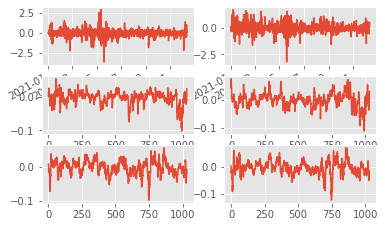

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=2)                  
train_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[0,0])
train_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[0,1])
validate_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[1,0])
validate_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[1,1])
test_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[2,0])
test_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[2,1])

### Export

In [59]:
import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
validate_csv = os.path.join(cwd, 'validate.csv')
test_csv = os.path.join(cwd, 'test.csv')
train_normalized.to_csv(train_csv, index=True)
validate_normalized.to_csv(validate_csv, index=True)
test_normalized.to_csv(test_csv, index=True)

## Wavelets

In [60]:
def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    #print("sigma: ",sigma)
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    #print("uthresh: ", uthresh)
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

### Create Training Set and Wavelet Transform

In [61]:
train_normalized = train.copy()
for i in normalize_columns:
    train_normalized[i] = waveletSmooth(train_normalized[i], level=1)[-len(train):]

### Create Validation Set and Wavelet Transform

In [64]:
temp = train_normalized.copy().filter(regex='closing|low|high|open|volume')
feats_norm_validate_WT = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
for j in range(validate_normalized.shape[0]):
    temp = np.append(temp, np.expand_dims(feats_norm_validate_WT.iloc[j,:], axis=0), axis=0)
    for i in range(feats_norm_validate_WT.shape[1]):
        feats_norm_validate_WT.iloc[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
      

In [65]:
validate_normalized.reset_index(inplace=True)
validate_normalized = validate_normalized.drop(normalize_columns, axis=1)
validate_normalized_wavelet = pd.concat((validate_normalized,feats_norm_validate_WT),axis=1)
validate_normalized_wavelet = validate_normalized_wavelet.drop('level_0', axis=1)
validate_normalized_wavelet = validate_normalized_wavelet.set_index('index')

,level_0,EOS:symbol,EOS:dayOfWeek_sin,EOS:dayOfWeek_cos,EOS:dayInYear_sin,EOS:dayInYear_cos,EOS:timeOfDay_sin,EOS:timeOfDay_cos,EOS:monthInYear_sin,EOS:monthInYear_cos,...,ADA:high_smooth,SOL:high_smooth,EOS:open_smooth,TRX:open_smooth,ADA:open_smooth,SOL:open_smooth,EOS:volume_smooth,TRX:volume_smooth,ADA:volume_smooth,SOL:volume_smooth
index,,,,,,,,,,,,,,,,,,,,,
2021-12-11 23:00:00,0,EOS/USDT,-8.660254e-01,0.5,-0.337523,0.941317,-2.449294e-16,1.000000,-2.449294e-16,1.000000,...,0.044581,0.011047,0.009888,0.002875,0.043813,-0.000563,-0.114188,0.124810,-0.059765,-0.098759
2021-12-12 00:00:00,1,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,0.000000e+00,1.000000,-2.449294e-16,1.000000,...,0.079810,0.012400,0.012490,0.010791,0.033258,0.009354,0.106529,0.643512,1.001945,-0.078451
2021-12-12 01:00:00,2,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,2.697968e-01,0.962917,-2.449294e-16,1.000000,...,0.074611,0.005498,-0.000160,0.005504,0.070817,0.001805,-0.491167,0.130087,0.094157,-0.453903
2021-12-12 02:00:00,3,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,5.195840e-01,0.854419,-2.449294e-16,1.000000,...,0.051192,-0.002804,0.001727,-0.000220,0.039859,-0.005265,0.979239,-0.223041,-0.238462,-0.441895
2021-12-12 03:00:00,4,EOS/USDT,-2.449294e-16,1.0,-0.321270,0.946988,7.308360e-01,0.682553,-2.449294e-16,1.000000,...,0.048348,0.000519,0.021890,0.000329,0.040832,-0.008229,0.217069,-0.422985,-0.360574,-0.434243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23 19:00:00,1028,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-8.878852e-01,0.460065,5.000000e-01,0.866025,...,-0.018172,-0.022557,-0.017591,-0.017169,-0.026073,-0.029922,0.250404,-0.311728,-0.110313,-0.082092
2022-01-23 20:00:00,1029,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-7.308360e-01,0.682553,5.000000e-01,0.866025,...,-0.011364,-0.017827,-0.023666,-0.020425,-0.034860,-0.039074,-0.104163,-0.447324,-0.240801,-0.224063
2022-01-23 21:00:00,1030,EOS/USDT,-2.449294e-16,1.0,0.385663,0.922640,-5.195840e-01,0.854419,5.000000e-01,0.866025,...,-0.008950,-0.015823,-0.009231,-0.008480,-0.015909,-0.021816,-0.410104,-0.522665,-0.413055,-0.382865


### Create Test Set and Wavelet Transform

In [68]:
temp_train = train_normalized.copy().filter(regex='closing|low|high|open|volume')
temp_val = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
temp = pd.concat((temp_train, temp_val),axis=0)
feats_norm_test_WT = test_normalized.copy().filter(regex='closing|low|high|open|volume')
for j in range(test_normalized.shape[0]):
   #first concatenate train with the latest validation sample
    temp = np.append(temp, np.expand_dims(feats_norm_test_WT.iloc[j,:], axis=0), axis=0)
    for i in range(feats_norm_test_WT.shape[1]):
        feats_norm_test_WT.iloc[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

In [69]:
test_normalized.reset_index(inplace=True)
test_normalized = test_normalized.drop(normalize_columns, axis=1)
test_normalized_wavelet = pd.concat((test_normalized,feats_norm_test_WT),axis=1)
test_normalized_wavelet = test_normalized_wavelet = test_normalized_wavelet.drop('level_0', axis=1)
test_normalized_wavelet = test_normalized_wavelet.set_index('index')
test_normalized_wavelet.drop('level_0', axis=1)

<AxesSubplot:xlabel='index'>

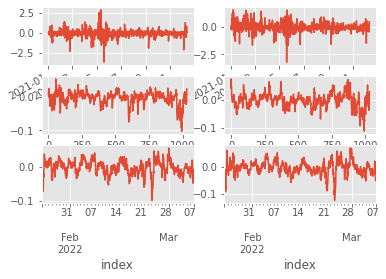

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2)                  
train_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[0,0])
train_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[0,1])
validate_normalized_wavelet['EOS:closing_smooth'].dropna().plot(ax=axes[1,0])
validate_normalized_wavelet['ADA:closing_smooth'].dropna().plot(ax=axes[1,1])
test_normalized_wavelet['EOS:closing_smooth'].dropna().plot(ax=axes[2,0])
test_normalized_wavelet['ADA:closing_smooth'].dropna().plot(ax=axes[2,1])

In [78]:
import os
cwd = os.getcwd()
train_wavelet_csv = os.path.join(cwd, 'train_wavelet.csv')
validate_wavelet_csv = os.path.join(cwd, 'validate_wavelet.csv')
test_wavelet_csv = os.path.join(cwd, 'test_wavelet.csv')

train_normalized.to_csv(train_wavelet_csv, index=True)
validate_normalized_wavelet.to_csv(validate_wavelet_csv, index=True)
test_normalized_wavelet.to_csv(test_wavelet_csv, index=True)

(array([7.54887208e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.54887208e-04, 1.50977442e-03, 5.28421046e-03, 9.05864649e-03,
        5.28421046e-03, 1.66075186e-02, 2.18917290e-02, 6.86947359e-02,
        9.88902242e-02, 3.02709770e-01, 8.04709764e-01, 1.99592178e+00,
        1.56261652e+00, 6.40144352e-01, 2.89876688e-01, 1.95515787e-01,
        9.20962394e-02, 8.15278185e-02, 2.79308267e-02, 9.81353370e-03,
        3.77443604e-03, 4.52932325e-03]),
 array([-3.20480208e+00, -3.04454304e+00, -2.88428401e+00, -2.72402497e+00,
        -2.56376593e+00, -2.40350689e+00, -2.24324785e+00, -2.08298881e+00,
        -1.92272977e+00, -1.76247073e+00, -1.60221170e+00, -1.44195266e+00,
        -1.28169362e+00, -1.12143458e+00, -9.61175542e-01, -8.00916503e-01,
        -6.40657465e-01, -4.80398426e-01, -3.20139388e-01, -1.59880349e-01,
         3.78689659e-04,  1.60637728e-01,  3.20896767e-01,  4.81155805e-01

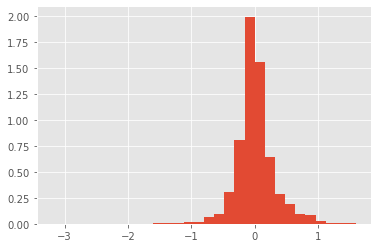

In [83]:
plt.hist(train_normalized['ADA:closing_smooth'], density=True, bins=30) 
#plt.hist(validate_normalized_wavelet['ADA:closing_smooth'], density=True, bins=30) 
#plt.hist(test_normalized_wavelet['ADA:closing_smooth'], density=True, bins=30) 